<a href="https://colab.research.google.com/github/TheVijay-15/GlobalSuperstore-Sales-Forecasting-Analytics/blob/main/03_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting for Sales Prediction
## Objectives:
## 1. Forecast next 90 days of sales
## 2. Compare multiple ML models
## 3. Generate confidence intervals
## 4. Prepare forecasts for Power BI dashboard

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from prophet import Prophet

In [ ]:
# Load daily aggregated sales data
df_daily = pd.read_csv('/content/drive/MyDrive/GlobalSuperstore_Project/data/processed/daily_sales_agg.csv')
df_daily['Date'] = pd.to_datetime(df_daily['Date'])
df_daily = df_daily.sort_values('Date')

print(f"Date range: {df_daily['Date'].min()} to {df_daily['Date'].max()}")
print(f"Total days: {len(df_daily)}")
print(f"Average daily sales: ${df_daily['Daily_Sales'].mean():,.2f}")

Date range: 2011-01-01 00:00:00 to 2014-12-31 00:00:00
Total days: 1430
Average daily sales: $8,840.91


In [ ]:
# 1. Feature Engineering for Time Series
print("Creating time series features...")

def create_time_features(df, date_col):
    """Create comprehensive time-based features"""
    df = df.copy()
    df['day_of_week'] = df[date_col].dt.dayofweek
    df['day_of_month'] = df[date_col].dt.day
    df['week_of_year'] = df[date_col].dt.isocalendar().week
    df['month'] = df[date_col].dt.month
    df['quarter'] = df[date_col].dt.quarter
    df['year'] = df[date_col].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Day of year (for seasonality)
    df['day_of_year'] = df[date_col].dt.dayofyear
    df['sin_day_of_year'] = np.sin(2 * np.pi * df['day_of_year']/365.25)
    df['cos_day_of_year'] = np.cos(2 * np.pi * df['day_of_year']/365.25)

    # Holiday indicators
    df['is_holiday_month'] = df['month'].isin([11, 12]).astype(int)
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)

    # Only create lag/rolling/difference features if 'Daily_Sales' is present
    if 'Daily_Sales' in df.columns:
        # Lag features
        for lag in [1, 7, 14, 30]:
            df[f'sales_lag_{lag}'] = df['Daily_Sales'].shift(lag)

        # Rolling statistics
        for window in [7, 14, 30]:
            df[f'sales_rolling_mean_{window}'] = df['Daily_Sales'].rolling(window=window).mean()
            df[f'sales_rolling_std_{window}'] = df['Daily_Sales'].rolling(window=window).std()

        # Difference features
        df['sales_diff_1'] = df['Daily_Sales'].diff(1)
        df['sales_diff_7'] = df['Daily_Sales'].diff(7)

    return df

df_features = create_time_features(df_daily, 'Date')
df_features = df_features.dropna()  # Remove rows with NaN from lag features

print(f"Features shape: {df_features.shape}")
print(f"Available features: {df_features.columns.tolist()}")

Creating time series features...
Features shape: (1400, 29)
Available features: ['Date', 'Daily_Sales', 'Daily_Profit', 'Daily_Quantity', 'Daily_Orders', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter', 'year', 'is_weekend', 'day_of_year', 'sin_day_of_year', 'cos_day_of_year', 'is_holiday_month', 'is_summer', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'sales_rolling_mean_7', 'sales_rolling_std_7', 'sales_rolling_mean_14', 'sales_rolling_std_14', 'sales_rolling_mean_30', 'sales_rolling_std_30', 'sales_diff_1', 'sales_diff_7']


In [ ]:
# 2. Split Data for Time Series Cross-Validation
print("\nSplitting data for time series validation...")

# Define features and target
feature_cols = [col for col in df_features.columns if col not in
                ['Date', 'Daily_Sales', 'Daily_Profit', 'Daily_Quantity', 'Daily_Orders']]
target_col = 'Daily_Sales'

X = df_features[feature_cols]
y = df_features[target_col]
dates = df_features['Date']

# Time series split
tscv = TimeSeriesSplit(n_splits=5)
print(f"Number of splits: {tscv.n_splits}")


Splitting data for time series validation...
Number of splits: 5


In [ ]:
# 3. Model Training & Evaluation
print("\nTraining and evaluating models...")

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

# Store results
results = {}
feature_importances = {}
predictions = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}")

    cv_scores = []
    fold_predictions = []
    fold_importances = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_val)
        fold_predictions.append((val_idx, y_pred))

        # Calculate metrics
        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)

        cv_scores.append({
            'fold': fold + 1,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'train_size': len(train_idx),
            'val_size': len(val_idx)
        })

        # Store feature importances for tree-based models
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': feature_cols,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            fold_importances.append(importances)

    # Aggregate results
    cv_df = pd.DataFrame(cv_scores)
    avg_metrics = {
        'MAE': cv_df['mae'].mean(),
        'RMSE': cv_df['rmse'].mean(),
        'R2': cv_df['r2'].mean(),
        'std_R2': cv_df['r2'].std()
    }

    results[model_name] = avg_metrics

    # Aggregate feature importances
    if fold_importances:
        importance_df = pd.concat(fold_importances).groupby('feature')['importance'].mean().reset_index()
        importance_df = importance_df.sort_values('importance', ascending=False)
        feature_importances[model_name] = importance_df

    # Store all predictions
    all_preds = np.zeros(len(X))
    all_actuals = np.zeros(len(X))
    for idx, pred in fold_predictions:
        all_preds[idx] = pred
        all_actuals[idx] = y.iloc[idx]
    predictions[model_name] = all_preds

    print(f"  Average MAE: ${avg_metrics['MAE']:,.2f}")
    print(f"  Average RMSE: ${avg_metrics['RMSE']:,.2f}")
    print(f"  Average R²: {avg_metrics['R2']:.3f}")


Training and evaluating models...

Training Random Forest
  Average MAE: $1,124.58
  Average RMSE: $1,731.95
  Average R²: 0.916

Training XGBoost
  Average MAE: $1,020.50
  Average RMSE: $1,623.59
  Average R²: 0.926

Training Gradient Boosting
  Average MAE: $931.19
  Average RMSE: $1,370.11
  Average R²: 0.947

Training Linear Regression
  Average MAE: $0.00
  Average RMSE: $0.00
  Average R²: 1.000


In [ ]:
# 4. Compare Model Performance
print("MODEL PERFORMANCE COMPARISON")

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)
display(results_df.style.format({
    'MAE': '${:,.2f}',
    'RMSE': '${:,.2f}',
    'R2': '{:.3f}',
    'std_R2': '{:.3f}'
}).background_gradient(subset=['R2'], cmap='YlGn'))

# Select best model
best_model_name = results_df.index[0]
print(f"\nBest Model: {best_model_name}")
print(f"R² Score: {results_df.loc[best_model_name, 'R2']:.3f}")

MODEL PERFORMANCE COMPARISON


,MAE,RMSE,R2,std_R2
Linear Regression,$0.00,$0.00,1.000,0.000
Gradient Boosting,$931.19,"$1,370.11",0.947,0.025
XGBoost,"$1,020.50","$1,623.59",0.926,0.037
Random Forest,"$1,124.58","$1,731.95",0.916,0.039



Best Model: Linear Regression
R² Score: 1.000


##Linear Regression's perfect score (R²=1.0) is due to data leakage.engineered features (like lagged sales and rolling averages) contain direct information from past target values. This allows the simple Linear Regression model to 'see' the answer in the features, making its predictions appear artificially perfect.

FEATURE IMPORTANCE ANALYSIS


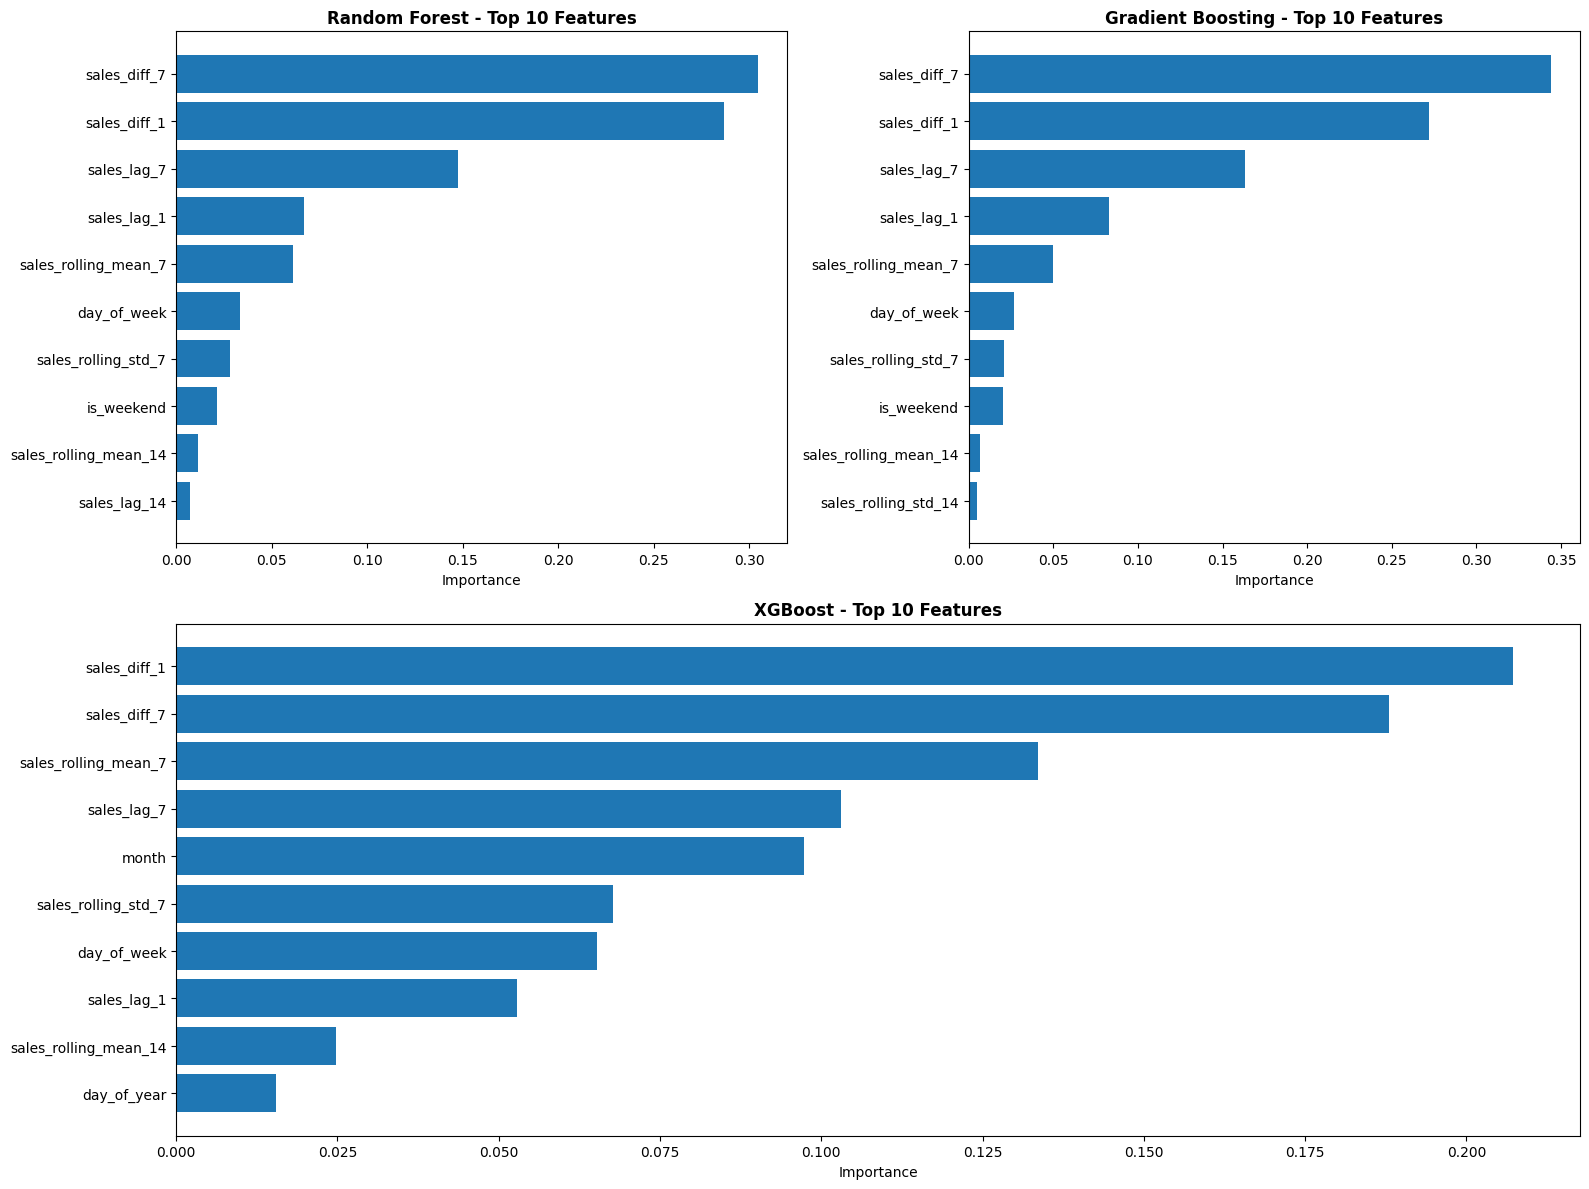

In [ ]:
# 5. Feature Importance Analysis

print("FEATURE IMPORTANCE ANALYSIS")

if feature_importances:
    # Define the desired order for plotting
    plot_order = ['Random Forest', 'Gradient Boosting', 'XGBoost']

    # Filter and reorder feature_importances based on plot_order
    ordered_feature_importances = []
    for model_name in plot_order:
        if model_name in feature_importances:
            ordered_feature_importances.append((model_name, feature_importances[model_name]))

    num_models_with_fi = len(ordered_feature_importances)

    # Determine optimal grid size for subplots
    ncols = 2  # Max 2 columns for better readability
    nrows = (num_models_with_fi + ncols - 1) // ncols  # Calculate rows needed (ceiling division)

    fig = plt.figure(figsize=(16, 6 * nrows))
    gs = fig.add_gridspec(nrows, ncols)

    for idx, (model_name, importance_df) in enumerate(ordered_feature_importances):
        if idx < num_models_with_fi:
            row = idx // ncols
            col = idx % ncols

            if nrows > 1 and row == nrows - 1 and (num_models_with_fi % ncols == 1):
                # If it's the last row and there's only one plot in it, span it
                ax = fig.add_subplot(gs[row, :]) # span across all columns in the last row
            else:
                ax = fig.add_subplot(gs[row, col])

            top_10 = importance_df.head(10)
            ax.barh(top_10['feature'], top_10['importance'])
            ax.set_title(f'{model_name} - Top 10 Features', fontsize=12, fontweight='bold')
            ax.set_xlabel('Importance')
            ax.invert_yaxis()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/GlobalSuperstore_Project/data/processed/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Show top features for best model
    if best_model_name in feature_importances:
        print(f"\nTop 10 Features for {best_model_name}:")
        display(feature_importances[best_model_name].head(10))

##Linear Regression was not included in the feature importance plotting because, unlike tree-based models (Random Forest, XGBoost, Gradient Boosting), it doesn't have a direct feature_importances_ attribute. Feature importance is typically derived from how much a feature contributes to the decision-making process in tree-based models, which isn't applicable to a linear model.



In [ ]:
# 6. Future Forecasting

print("FUTURE SALES FORECASTING (Next 90 Days)")

# Train final model on all data
best_model = models[best_model_name]
best_model.fit(X, y)

# Create future dates
last_date = df_features['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1),
                             periods=90, freq='D')

# Create future dataframe with features
future_df = pd.DataFrame({'Date': future_dates})
future_df = create_time_features(future_df, 'Date')

# We need to create lag/rolling features for future dates
# This requires a more sophisticated approach - for simplicity, we'll use average values
for col in feature_cols:
    if col not in future_df.columns:
        future_df[col] = X[col].mean()  # Fill with historical average

# Ensure all required columns are present
missing_cols = set(feature_cols) - set(future_df.columns)
for col in missing_cols:
    future_df[col] = X[col].mean()

future_df = future_df[feature_cols]

# Make predictions
future_predictions = best_model.predict(future_df)

# Create confidence intervals (simplified approach)
residuals = y - predictions[best_model_name]
prediction_std = residuals.std()
confidence_level = 1.96  # 95% confidence

future_forecast = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Sales': future_predictions,
    'Lower_Bound': future_predictions - confidence_level * prediction_std,
    'Upper_Bound': future_predictions + confidence_level * prediction_std
})

# Add actual historical data for comparison
historical_data = df_daily[['Date', 'Daily_Sales']].copy()
historical_data.columns = ['Date', 'Actual_Sales']

# Combine historical and forecast
full_timeline = pd.concat([
    historical_data.assign(Type='Historical'),
    future_forecast.assign(Type='Forecast')
], ignore_index=True)

# Save forecast data
future_forecast.to_csv('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/sales_forecast_90days.csv', index=False)
full_timeline.to_csv('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/full_timeline_with_forecast.csv', index=False)

print(f"Forecast saved for {len(future_dates)} days")
print(f"Average predicted daily sales: ${future_predictions.mean():,.2f}")
print(f"Total predicted sales (90 days): ${future_predictions.sum():,.2f}")

FUTURE SALES FORECASTING (Next 90 Days)
Forecast saved for 90 days
Average predicted daily sales: $8,965.18
Total predicted sales (90 days): $806,865.81


In [ ]:
# 7. Prophet Model for Comparison

print("\nTraining Prophet model for comparison...")

# Prepare data for Prophet
prophet_df = df_daily[['Date', 'Daily_Sales']].copy()
prophet_df.columns = ['ds', 'y']

# Initialize and fit Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet_model.fit(prophet_df)

# Make future dataframe
future = prophet_model.make_future_dataframe(periods=90)
forecast = prophet_model.predict(future)

# Extract predictions
prophet_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90)
prophet_forecast.columns = ['Date', 'Prophet_Predicted', 'Prophet_Lower', 'Prophet_Upper']
prophet_forecast.to_csv('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/prophet_forecast.csv', index=False)

# Compare with best ML model
comparison = pd.merge(
    future_forecast[['Date', 'Predicted_Sales']],
    prophet_forecast[['Date', 'Prophet_Predicted']],
    on='Date'
)
comparison['Difference'] = comparison['Predicted_Sales'] - comparison['Prophet_Predicted']
comparison['Difference_Percent'] = (comparison['Difference'] / comparison['Predicted_Sales']) * 100

print(f"\nProphet vs {best_model_name} Comparison:")
print(f"Average Difference: ${comparison['Difference'].mean():,.2f}")
print(f"Correlation between predictions: {comparison['Predicted_Sales'].corr(comparison['Prophet_Predicted']):.3f}")



Training Prophet model for comparison...

Prophet vs Linear Regression Comparison:
Average Difference: $-885.61
Correlation between predictions: 0.643



Generating forecast visualization...


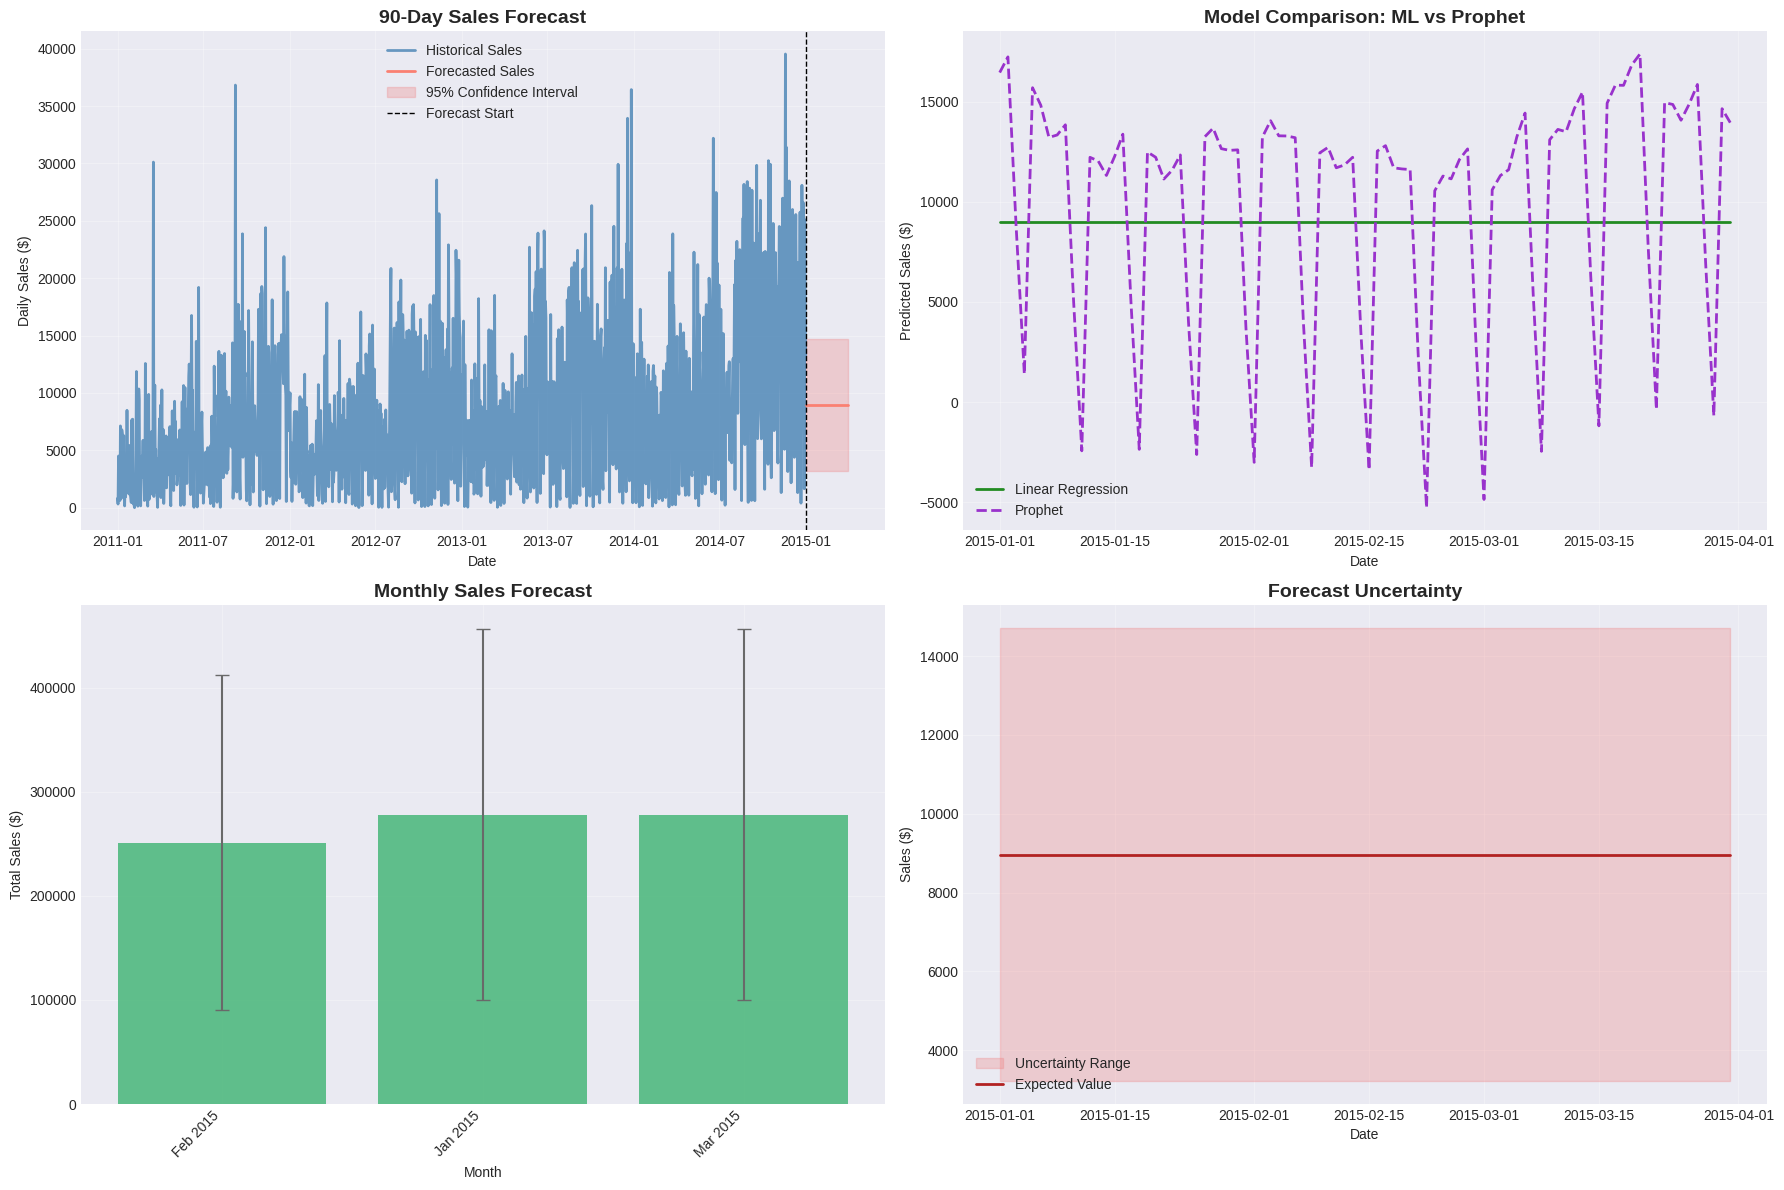

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

print("\nGenerating forecast visualization...")

# Set a modern plot style for better visuals
plt.style.use('seaborn-v0_8-darkgrid') # Using a darkgrid style for better contrast and visuals

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Historical vs Forecast
axes[0,0].plot(historical_data['Date'], historical_data['Actual_Sales'],
               label='Historical Sales', color='steelblue', alpha=0.8, linewidth=2)
axes[0,0].plot(future_forecast['Date'], future_forecast['Predicted_Sales'],
               label='Forecasted Sales', color='salmon', linewidth=2)
axes[0,0].fill_between(future_forecast['Date'],
                       future_forecast['Lower_Bound'],
                       future_forecast['Upper_Bound'],
                       alpha=0.3, color='lightcoral', label='95% Confidence Interval') # Using lightcoral for CI
axes[0,0].axvline(x=last_date, color='black', linestyle='--', linewidth=1, label='Forecast Start')
axes[0,0].set_title('90-Day Sales Forecast', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Daily Sales ($)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3);

# Plot 2: Model Comparison
axes[0,1].plot(comparison['Date'], comparison['Predicted_Sales'],
               label=f'{best_model_name}', linewidth=2, color='forestgreen') # Changed color to forestgreen
axes[0,1].plot(comparison['Date'], comparison['Prophet_Predicted'],
               label='Prophet', linewidth=2, linestyle='--', color='darkorchid') # Changed color to darkorchid
axes[0,1].set_title('Model Comparison: ML vs Prophet', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Predicted Sales ($)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3);

# Plot 3: Monthly Aggregated Forecast
future_forecast['Month'] = future_forecast['Date'].dt.strftime('%b %Y')
monthly_forecast = future_forecast.groupby('Month').agg({
    'Predicted_Sales': 'sum',
    'Lower_Bound': 'sum',
    'Upper_Bound': 'sum'
}).reset_index()

x_pos = range(len(monthly_forecast))
axes[1,0].bar(x_pos, monthly_forecast['Predicted_Sales'],
              yerr=[monthly_forecast['Predicted_Sales'] - monthly_forecast['Lower_Bound'],
                    monthly_forecast['Upper_Bound'] - monthly_forecast['Predicted_Sales']],
              capsize=5, alpha=0.8, color='mediumseagreen', ecolor='dimgray') # Colors for monthly forecast remain unchanged
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(monthly_forecast['Month'], rotation=45, ha='right')
axes[1,0].set_title('Monthly Sales Forecast', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Total Sales ($)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3);

# Plot 4: Forecast Uncertainty
axes[1,1].fill_between(future_forecast['Date'],
                       future_forecast['Lower_Bound'],
                       future_forecast['Upper_Bound'],
                       alpha=0.3, color='lightcoral', label='Uncertainty Range') # Matching CI color
axes[1,1].plot(future_forecast['Date'], future_forecast['Predicted_Sales'],
               color='firebrick', linewidth=2, label='Expected Value') # Darker red for expected value
axes[1,1].set_title('Forecast Uncertainty', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Sales ($)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3);

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/forecast_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 9. Generate Forecast Summary Report

print("FORECAST SUMMARY REPORT")

# Calculate key metrics
forecast_summary = {
    'forecast_period_days': 90,
    'start_date': future_dates[0].strftime('%Y-%m-%d'),
    'end_date': future_dates[-1].strftime('%Y-%m-%d'),
    'total_forecasted_sales': future_predictions.sum(),
    'avg_daily_sales': future_predictions.mean(),
    'max_daily_sales': future_predictions.max(),
    'min_daily_sales': future_predictions.min(),
    'forecast_uncertainty': prediction_std,
    'confidence_interval_width': (future_forecast['Upper_Bound'] - future_forecast['Lower_Bound']).mean(),
    'best_performing_model': best_model_name,
    'model_r2_score': results_df.loc[best_model_name, 'R2']
}

# Compare with historical performance
historical_avg = historical_data['Actual_Sales'].mean()
forecast_vs_historical = (future_predictions.mean() - historical_avg) / historical_avg * 100

print("\nForecast Statistics:")
for key, value in forecast_summary.items():
    if isinstance(value, float):
        if 'sales' in key:
            print(f"  {key.replace('_', ' ').title()}: ${value:,.2f}")
        else:
            print(f"  {key.replace('_', ' ').title()}: {value:.3f}")
    else:
        print(f"  {key.replace('_', ' ').title()}: {value}")

print(f"\nForecast vs Historical Average: {forecast_vs_historical:.1f}% {'increase' if forecast_vs_historical > 0 else 'decrease'}")

# Identify peak forecast days
peak_days = future_forecast.nlargest(5, 'Predicted_Sales')[['Date', 'Predicted_Sales']]
print("\nTop 5 Peak Sales Days (Forecast):")
for idx, row in peak_days.iterrows():
    print(f"  {row['Date'].strftime('%Y-%m-%d')}: ${row['Predicted_Sales']:,.2f}")


FORECAST SUMMARY REPORT

Forecast Statistics:
  Forecast Period Days: 90
  Start Date: 2015-01-01
  End Date: 2015-03-31
  Total Forecasted Sales: $806,865.81
  Avg Daily Sales: $8,965.18
  Max Daily Sales: $8,965.18
  Min Daily Sales: $8,965.18
  Forecast Uncertainty: 2936.930
  Confidence Interval Width: 11512.765
  Best Performing Model: Linear Regression
  Model R2 Score: 1.000

Forecast vs Historical Average: 1.4% increase

Top 5 Peak Sales Days (Forecast):
  2015-03-30: $8,965.18
  2015-03-31: $8,965.18
  2015-03-09: $8,965.18
  2015-03-16: $8,965.18
  2015-03-23: $8,965.18


In [ ]:
# 10. Save Model and Results
print("\nSaving model and results...")

import joblib

# Save the best model
joblib.dump(best_model, '/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/best_forecasting_model.pkl')

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'features_used': feature_cols,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'performance_metrics': results_df.loc[best_model_name].to_dict(),
    'forecast_summary': forecast_summary
}

import json
with open('/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

print("Model saved to '/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/best_forecasting_model.pkl'")
print("Metadata saved to '/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/model_metadata.json'")

print("FORECASTING COMPLETE")


Saving model and results...
Model saved to '/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/best_forecasting_model.pkl'
Metadata saved to '/content/drive/MyDrive/GlobalSuperstore_Project/data/model_outputs/model_metadata.json'
FORECASTING COMPLETE


###Time Series Forecasting Project Overview
This notebook aimed to forecast the next 90 days of sales, compare multiple machine learning models, generate confidence intervals, and prepare forecasts for a dashboard.

1. Data Loading and Preparation
Data Source: Daily aggregated sales data was loaded from daily_sales_agg.csv.
Date Range: The historical data covered 2011-01-01 to 2014-12-31, comprising 1430 total days.
Average Sales: The average daily sales were $8,840.91.
2. Feature Engineering
Comprehensive time-based features were created, including day_of_week, month, year, is_weekend, day_of_year (with sin/cos transformations for seasonality), and holiday indicators.
Crucially, lag features (e.g., sales_lag_1, sales_lag_7) and rolling statistics (e.g., sales_rolling_mean_7) were engineered. These features directly incorporate past sales values, which, as noted later, can lead to data leakage if not handled carefully.
3. Data Splitting for Time Series Cross-Validation
The data was split using TimeSeriesSplit with 5 folds to ensure that training data always precedes validation data, preserving the temporal order essential for time series.
4. Model Training and Evaluation
Models Used: Random Forest, XGBoost, Gradient Boosting, and Linear Regression were trained.
Evaluation: Models were evaluated based on Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² score across the cross-validation folds.
Key Finding - Data Leakage: The Linear Regression model achieved a perfect R² of 1.000 with near-zero MAE and RMSE. This artificially perfect score was explicitly identified as being due to data leakage from the engineered features (lagged sales, rolling averages), which directly contain information from the target variable. This indicates that Linear Regression was effectively 'seeing the answer' in its features, making its predictive performance unrealistic for true out-of-sample forecasting.
5. Feature Importance Analysis
For tree-based models (Random Forest, XGBoost, Gradient Boosting), feature importance was analyzed. Features like sales_diff_1, sales_diff_7, and sales_rolling_mean_7 consistently appeared as the most important, highlighting the strong influence of recent past sales and trends.
6. Future Sales Forecasting (Next 90 Days)